# Monthly Corn Price Forecasting using SARIMA

In [1]:
# Project 3      
#importing libraries 
import pandas as pd
import numpy as np
import seaborn as sns 
import datetime 
import plotly.express as px
import os
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline
import hvplot.pandas
from statsmodels.tsa.arima_model import ARIMA

## 1. Data Import and Cleanup

In [2]:
# Read in corn actual price and sort by date
corn_act_prices = pd.read_csv(Path("../Resources/corn-prices-historical-chart-data.csv"), index_col="date", infer_datetime_format=True, parse_dates=True).sort_index()
# Drop corn actual price data prior to 2000
corn_act_prices = corn_act_prices.loc['2000-1-1': '2020-10-31']
# Rename the columns
corn_act_prices.columns.values[0] = "Corn_Price"
corn_act_prices.index.names = ['Date']
corn_act_prices.head()

,Corn_Price
Date,
2000-01-03,2.0075
2000-01-04,2.0300
2000-01-05,2.0300
2000-01-06,2.0375
2000-01-07,2.0700


In [3]:
# Drop nulls from Corn DataFrame
corn_act_prices.dropna(inplace=True)

In [4]:
# Checking Timestamp
type(corn_act_prices.index[3])

pandas._libs.tslibs.timestamps.Timestamp

In [5]:
monthly_corn_data = corn_act_prices["Corn_Price"].resample('M').mean().to_frame()
# Save the monthly corn data without NA values into a csv file
monthly_corn_data.to_csv("../Resources/monthly_corn_data.csv")
monthly_corn_data ,  monthly_corn_data.shape

(            Corn_Price
 Date                  
 2000-01-31    2.159875
 2000-02-29    2.205350
 2000-03-31    2.306848
 2000-04-30    2.283895
 2000-05-31    2.395114
 ...                ...
 2020-06-30    3.278614
 2020-07-31    3.311591
 2020-08-31    3.262881
 2020-09-30    3.662738
 2020-10-31    3.988977
 
 [250 rows x 1 columns],
 (250, 1))

In [6]:
# Check Data Types, count of each column,checking nulls and share of the DataFrame
monthly_corn_data.dtypes, monthly_corn_data.count(), monthly_corn_data.isnull().sum(), monthly_corn_data.shape

(Corn_Price    float64
 dtype: object,
 Corn_Price    250
 dtype: int64,
 Corn_Price    0
 dtype: int64,
 (250, 1))

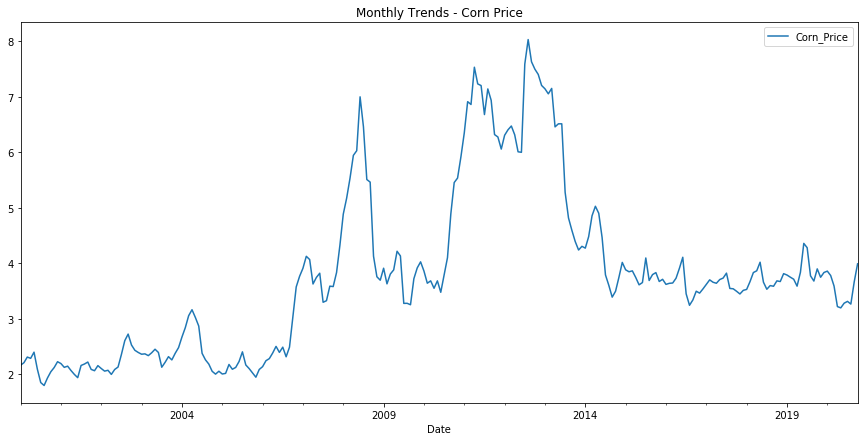

In [7]:
# Plotting and saving the Monthly Corn price trends.
monthly_corn_data.plot(title='Monthly Trends - Corn Price', figsize=(15,7))
plt.savefig("../Images/Monthly_Trends_Corn_Price.png")

## 2. Decomposition Using a Hodrick-Prescott Filter
Using a Hodrick-Prescott Filter, decompose the Corn Price into a trend, noise and seasonality.

C:\Users\Anirban\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


<Figure size 432x288 with 0 Axes>

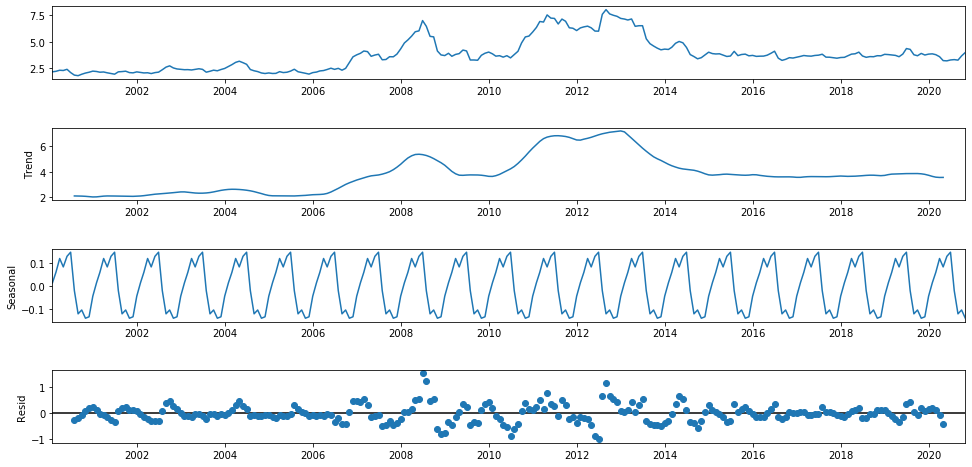

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(monthly_corn_data, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 7)

## Variable Selection based on Stationarity
Comparing Absolute Corn Price versus other transformed metrics to conclude which variable is better fit for model development 

In [9]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
       
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

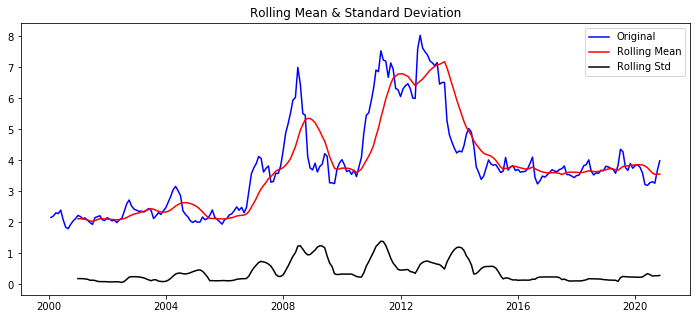

Results of Dickey-Fuller Test:
Test Statistic                  -2.040353
p-value                          0.269165
#Lags Used                      16.000000
Number of Observations Used    233.000000
Critical Value (1%)             -3.458731
Critical Value (5%)             -2.874026
Critical Value (10%)            -2.573424
dtype: float64


In [10]:
# Checking Stationarity using original Corn Price, Rolling Mean and Rolling std with window of 12
test_stationarity(monthly_corn_data.Corn_Price)
# plt.savefig("../Images/Stationarity_Corn.png")

From abover we can observe that the time series is not stationary, and our test_stationarity function confirms what we see. So now we need to transform the data to make it more stationary. We will try various transformations to stationarize the data.

1.Logarithmic
2.First Difference
3.Seasonal Difference
4.Seasonal Adjustment

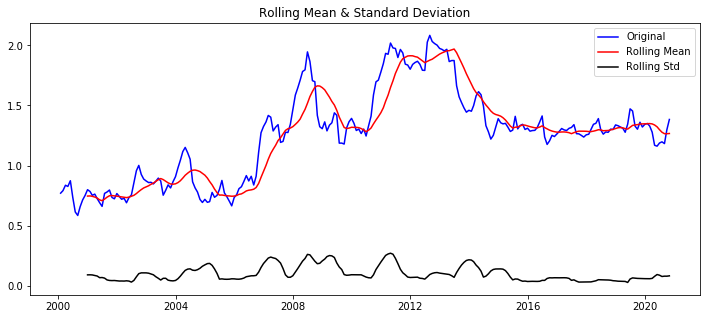

Results of Dickey-Fuller Test:
Test Statistic                  -2.077476
p-value                          0.253668
#Lags Used                       1.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


In [11]:
# Checking Stationarity using original Log of Corn Price, Rolling Mean and Rolling std with window of 12
monthly_corn_data["corn_log"]= monthly_corn_data.Corn_Price.apply(lambda x: np.log(x))  
test_stationarity(monthly_corn_data.corn_log)
# plt.savefig("../Images/Stationarity_Corn_log.png")

We observe that by even taking the Logarithmic of the Corn Price does not make the times series stationary! Hence we will try the first difference.

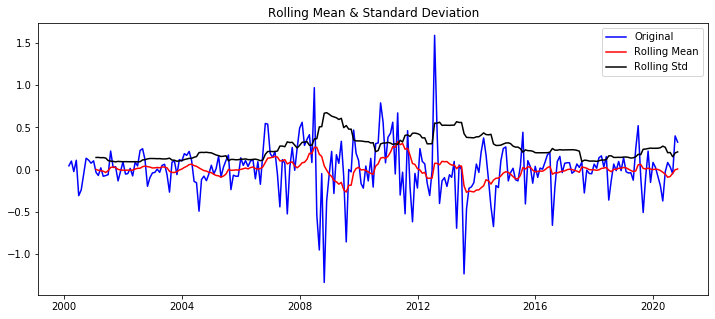

Results of Dickey-Fuller Test:
Test Statistic                  -4.156485
p-value                          0.000780
#Lags Used                      14.000000
Number of Observations Used    234.000000
Critical Value (1%)             -3.458608
Critical Value (5%)             -2.873972
Critical Value (10%)            -2.573396
dtype: float64


In [12]:
# Checking Stationarity using First Difference Corn Price, Rolling Mean and Rolling std with window of 12
monthly_corn_data['first_difference'] = monthly_corn_data.Corn_Price - monthly_corn_data.Corn_Price.shift(1)  
test_stationarity(monthly_corn_data.first_difference.dropna(inplace=False))
# plt.savefig("../Images/Stationarity_Corn_fd.png")

The first difference of the data has eliminated the overall trend from the data and improved the stationarity but we will try further transformations to enhance the accuracy!

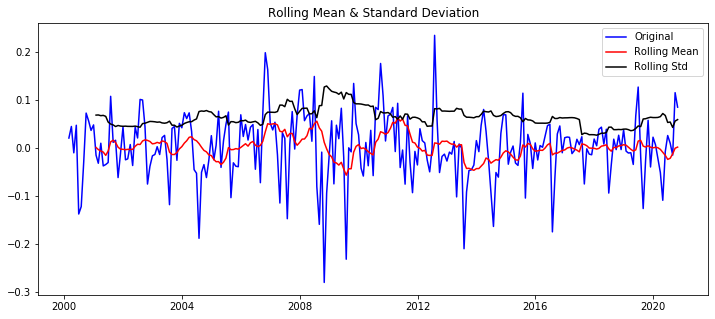

Results of Dickey-Fuller Test:
Test Statistic                -1.177172e+01
p-value                        1.085959e-21
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


In [13]:
# Checking Stationarity using Log of First Difference Corn Price, Rolling Mean and Rolling std with window of 12
monthly_corn_data['log_first_difference'] = monthly_corn_data.corn_log - monthly_corn_data.corn_log.shift(1)  
test_stationarity(monthly_corn_data.log_first_difference.dropna(inplace=False))
# plt.savefig("../Images/Stationarity_Corn_logfd.png")

Log of the first difference has not made much difference to the statinarity of the data! We will proceed to trying seasonal differences and log of it!

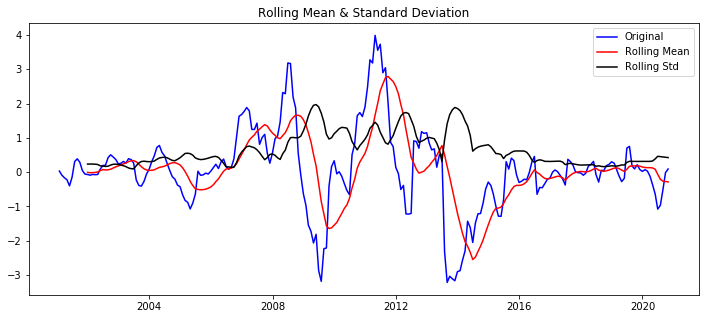

Results of Dickey-Fuller Test:
Test Statistic                  -3.082705
p-value                          0.027860
#Lags Used                      15.000000
Number of Observations Used    222.000000
Critical Value (1%)             -3.460154
Critical Value (5%)             -2.874649
Critical Value (10%)            -2.573757
dtype: float64


In [14]:
# Checking Stationarity using Log of Seasonal Difference Corn Price, Rolling Mean and Rolling std with window of 12
monthly_corn_data['seasonal_diff'] = monthly_corn_data.Corn_Price - monthly_corn_data.Corn_Price.shift(12)  
test_stationarity(monthly_corn_data.seasonal_diff.dropna(inplace=False))
# plt.savefig("../Images/Stationarity_Corn_sd.png")

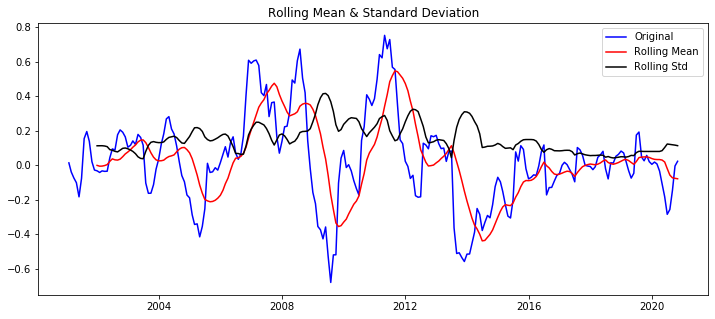

Results of Dickey-Fuller Test:
Test Statistic                  -3.094817
p-value                          0.026939
#Lags Used                      15.000000
Number of Observations Used    222.000000
Critical Value (1%)             -3.460154
Critical Value (5%)             -2.874649
Critical Value (10%)            -2.573757
dtype: float64


In [15]:
# Checking Stationarity using Log of Seasonal Difference Corn Price, Rolling Mean and Rolling std with window of 12
monthly_corn_data['log_seasonal_diff'] = monthly_corn_data.corn_log - monthly_corn_data.corn_log.shift(12)
test_stationarity(monthly_corn_data.log_seasonal_diff.dropna(inplace=False))
# plt.savefig("../Images/Stationarity_Corn_logsd.png")

Compared to the original data there is an improvement in data stationarity by using seasonal difference and log of it, but we are not there yet. The next step is to take a first difference of the seasonal difference!

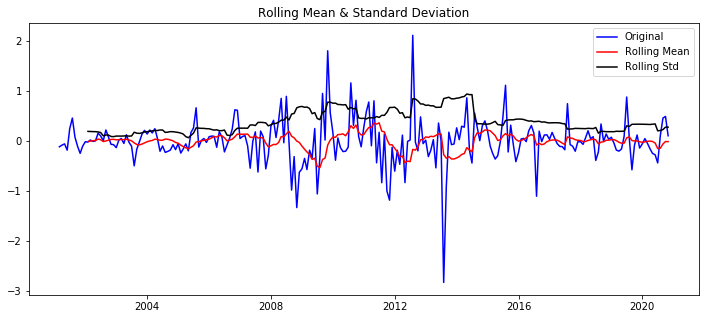

Results of Dickey-Fuller Test:
Test Statistic                  -4.703835
p-value                          0.000083
#Lags Used                      14.000000
Number of Observations Used    222.000000
Critical Value (1%)             -3.460154
Critical Value (5%)             -2.874649
Critical Value (10%)            -2.573757
dtype: float64


<Figure size 432x288 with 0 Axes>

In [16]:
# Checking Stationarity using Log of Seasonal Difference Corn Price, Rolling Mean and Rolling std with window of 12
monthly_corn_data['seasonal_first_diff'] = monthly_corn_data.first_difference - monthly_corn_data.first_difference.shift(12)
test_stationarity(monthly_corn_data.seasonal_first_diff.dropna(inplace=False))
plt.savefig("../Images/Stationarity_Corn_fd_seasonal.png")

Comparing all the data transformation, T-test and by the p-value, taking the seasonal first difference has now made our data stationary. I also looked at doing this differencing for the log values, but it didn’t make the data any more stationary!

In [17]:
# Checking a sample of the data
monthly_corn_data.head(14)

,Corn_Price,corn_log,first_difference,log_first_difference,seasonal_diff,log_seasonal_diff,seasonal_first_diff
Date,,,,,,,
2000-01-31,2.159875,0.770050,NaN,NaN,NaN,NaN,NaN
2000-02-29,2.205350,0.790886,0.045475,0.020836,NaN,NaN,NaN
2000-03-31,2.306848,0.835882,0.101498,0.044996,NaN,NaN,NaN
2000-04-30,2.283895,0.825882,-0.022953,-0.010000,NaN,NaN,NaN
2000-05-31,2.395114,0.873431,0.111219,0.047548,NaN,NaN,NaN
2000-06-30,2.086932,0.735695,-0.308182,-0.137736,NaN,NaN,NaN
2000-07-31,1.846750,0.613427,-0.240182,-0.122268,NaN,NaN,NaN
2000-08-31,1.793761,0.584314,-0.052989,-0.029113,NaN,NaN,NaN
2000-09-30,1.929500,0.657261,0.135739,0.072946,NaN,NaN,NaN


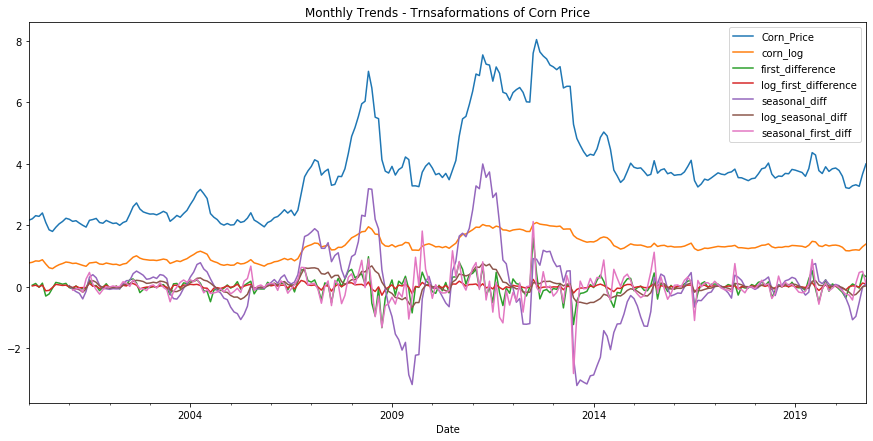

In [18]:
# Plotting and saving the Monthly Corn price trends.
monthly_corn_data.plot(title='Monthly Trends - Trnsaformations of Corn Price', figsize=(15,7))
plt.savefig("../Images/Monthly_Trends_Transformations_Corn_Price.png")

## 3. Plotting the ACF and PACF charts to find the optimal parameters
The next step is to determine the tuning parameters of the model by looking at the autocorrelation and partial autocorrelation graphs. Selecting the appropriate AR, MA, SAR, and MAR terms for the model is based on best practices and modellers experience!

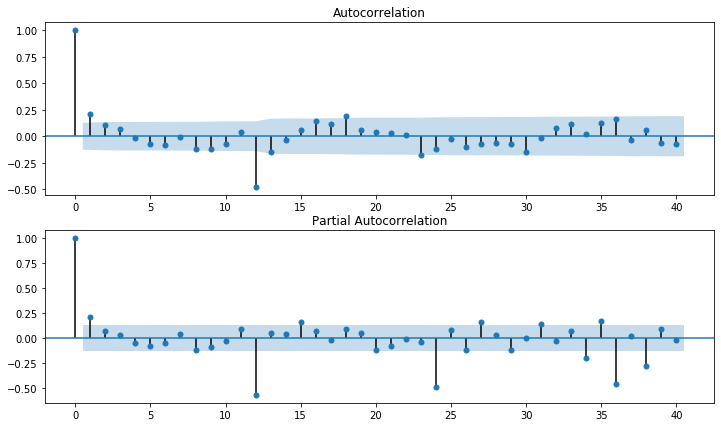

In [19]:
import statsmodels.api as sm  
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(monthly_corn_data.seasonal_first_diff.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(monthly_corn_data.seasonal_first_diff.iloc[13:], lags=40, ax=ax2)

## 4. Building SARIMA Models

In [20]:
mod = sm.tsa.statespace.SARIMAX(monthly_corn_data.Corn_Price, trend='n', order=(2,1,2), seasonal_order=(1,1,1,12))
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2440      0.266      4.684      0.000       0.723       1.765
ar.L2         -0.3326      0.145     -2.286      0.022      -0.618      -0.047
ma.L1         -1.0027      0.275     -3.641      0.000      -1.542      -0.463
ma.L2          0.1034      0.167      0.620      0.536      -0.224       0.431
ar.S.L12      -0.1355      0.048     -2.820      0.005      -0.230      -0.041
ma.S.L12      -0.9996     20.844     -0.048      0.962     -41.854      39.855
sigma2         0.0789      1.643      0.048      0.962      -3.142       3.300


C:\Users\Anirban\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [21]:
mod = sm.tsa.statespace.SARIMAX(monthly_corn_data.Corn_Price, trend='n', order=(1,1,0), seasonal_order=(1,1,0,12))
results = mod.fit()
# save model
results.save("../Model_Results/SARIMA_model.pkl")
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2655      0.059      4.478      0.000       0.149       0.382
ar.S.L12      -0.4946      0.028    -17.419      0.000      -0.550      -0.439
sigma2         0.1420      0.008     18.621      0.000       0.127       0.157


## 5. Validating Forecasts

We will use the model to forecast for time periods that we already have data for, so we can understand how accurate are the forecasts. We have used 5 years of foreacast!

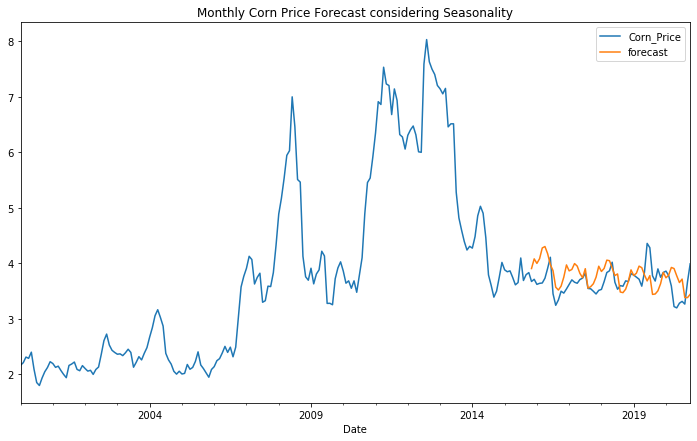

In [22]:
monthly_corn_data['forecast'] = results.predict(start = 190, end= 250, dynamic= True)  
monthly_corn_data[['Corn_Price', 'forecast']].plot(title = 'Monthly Corn Price Forecast considering Seasonality', figsize=(12, 7)) 
plt.savefig('../Images/ts_df_predict.png', bbox_inches='tight')

In [23]:
# Looking at the sample of the predictions versus actual
monthly_corn_data.tail(61)

,Corn_Price,corn_log,first_difference,log_first_difference,seasonal_diff,log_seasonal_diff,seasonal_first_diff,forecast
Date,,,,,,,,
2015-10-31,3.830568,1.343013,0.035925,0.009423,0.336438,0.091929,-0.070110,NaN
2015-11-30,3.670300,1.300273,-0.160268,-0.042740,-0.075147,-0.020268,-0.411585,3.903823
2015-12-31,3.709773,1.310971,0.039473,0.010697,-0.304659,-0.078925,-0.229512,4.078392
2016-01-31,3.618421,1.286038,-0.091352,-0.024933,-0.262579,-0.070055,0.042080,3.996499
2016-02-29,3.637125,1.291194,0.018704,0.005156,-0.208612,-0.055772,0.053967,4.081455
...,...,...,...,...,...,...,...,...
2020-06-30,3.278614,1.187421,0.084489,0.026107,-1.078961,-0.284495,-0.436382,3.651038
2020-07-31,3.311591,1.197429,0.032977,0.010008,-0.968523,-0.256551,0.110439,3.713490
2020-08-31,3.262881,1.182611,-0.048710,-0.014818,-0.509255,-0.145031,0.459267,3.381390


We will use the MSE (Mean Squared Error), which summarizes the average error of our forecasts to quantify the accuracy of our forecasts. For each predicted value, we compute its distance to the true value and square the result. The results need to be squared so that positive/negative differences do not cancel each other out when we compute the overall mean.

In [24]:
# Compute the mean square error
mse = ((monthly_corn_data['forecast'] - monthly_corn_data['Corn_Price']) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 3)))

The Mean Squared Error of our forecasts is 0.097


The MSE of our one-step ahead forecasts yields a value of 0.097, which is very low as it is close to 0. An MSE of 0 would that the estimator is predicting observations of the parameter with perfect accuracy, which would be an ideal scenario but it not typically possible!

## 6. Producing and Visualizing Forecasts

In [25]:
# Get forecast of next 6 months ahead in future from Novemeber 2020 to April 2021
pred_uc = results.get_forecast(steps=6)
print(pred_uc)

In [26]:
# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()
pred_ci

,lower Corn_Price,upper Corn_Price
2020-11-30,3.212612,4.689589
2020-12-31,2.885406,5.267668
2021-01-31,2.533386,5.626766
2021-02-28,2.179173,5.863288
2021-03-31,1.809839,6.005770
2021-04-30,1.332287,5.984900


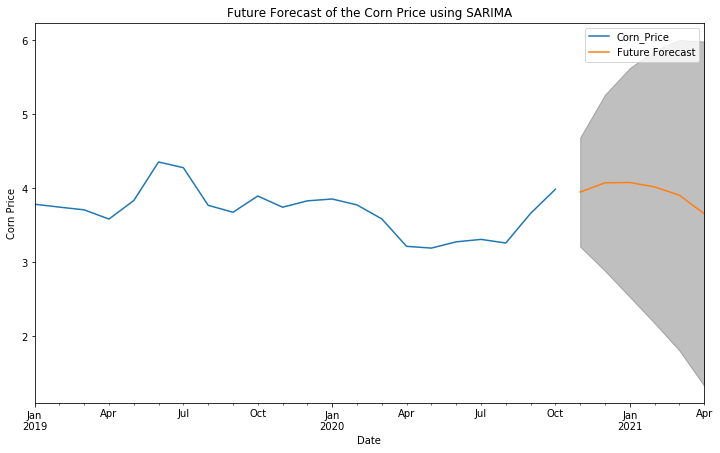

<Figure size 432x288 with 0 Axes>

In [27]:
monthly_corn_data = monthly_corn_data[["Corn_Price"]] 
ax = monthly_corn_data['2019' :].plot(label='observed', figsize=(12, 7))
future_forecasted_values = pred_uc.predicted_mean
future_forecasted_values.plot(ax=ax, label='Future Forecast', title = "Future Forecast of the Corn Price using SARIMA")
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Corn Price')

plt.legend()
plt.show()

plt.savefig("../Images/SARIMA_Forecasted_Trends_Corn_Price.png", bbox_inches='tight')

In [28]:
print(future_forecasted_values)

2020-11-30    3.951101
2020-12-31    4.076537
2021-01-31    4.080076
2021-02-28    4.021231
2021-03-31    3.907805
2021-04-30    3.658594
Freq: M, dtype: float64
